In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
%cd /content/drive/MyDrive/ML2021

/content/drive/MyDrive/ML2021


In [3]:
import numpy as np
import torch
import torch.nn as nn
import torchvision
from torch.utils.data import DataLoader
import torch.nn.functional as F

In [ ]:
def l2_norm(input,axis=1):
    norm = torch.norm(input,2,axis,True)
    output = torch.div(input, norm)
    return output

class se_block(nn.Module):
    def __init__(self, channels, reduction):
        super(se_block, self).__init__()
        self.avg_pool = nn.AdaptiveAvgPool2d(1)
        self.fc1 = nn.Conv2d(channels, channels//reduction, kernel_size=1, stride=1, padding=0, bias=False)
        self.relu = nn.PReLU(channels//reduction)

        self.fc2 = nn.Conv2d(channels//reduction, channels, kernel_size=1, stride=1, padding=0, bias=False)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        module_input = x
        x = self.avg_pool(x)
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        x = self.sigmoid(x)
        return module_input * x

class separable_conv2d(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size, padding, expansion=1, stride=1,dw_bn_out=True, dw_relu_out=True, pw_bn_out=True, pw_relu_out=True, group_base=8):
        super(separable_conv2d, self).__init__()
        #depthwise
        assert in_channels % group_base == 0
        self.dw_conv = nn.Conv2d(in_channels, in_channels*expansion, kernel_size=kernel_size, stride=stride, padding=padding, bias=False, groups=in_channels//group_base)
        if dw_bn_out:
            self.dw_bn = nn.BatchNorm2d(in_channels*expansion)
        else:
            self.dw_bn = nn.Sequential()
        if dw_relu_out:
            self.dw_relu = nn.PReLU(in_channels*expansion)
        else:
            self.dw_relu = nn.Sequential()

        #pointwise
        self.pw_conv = nn.Conv2d(in_channels*expansion, out_channels, kernel_size=1, stride=1, padding=0, bias=False)
        if pw_bn_out:
            self.pw_bn = nn.BatchNorm2d(out_channels)
        else: 
            self.pw_bn = nn.Sequential()
        if pw_relu_out:
            self.pw_relu = nn.PReLU(out_channels)
        else:
            self.pw_relu = nn.Sequential()

    def forward(self, x):
        x = self.dw_conv(x)
        x = self.dw_bn(x)
        x = self.dw_relu(x)

        x = self.pw_conv(x)
        x = self.pw_bn(x)
        x = self.pw_relu(x)

        return x

#Norm Block
class vargnet_block(nn.Module):
    def __init__(self, channels_1, channels_2, channels_3, reduction, expansion=2, multiplier=1, kernel_size=3, stride=1, dilate=1, dim_match=True, use_se=True):
        super(vargnet_block, self).__init__()
        pad = ((kernel_size-1) *dilate + 1) // 2
        if not dim_match:
            self.short_cut = separable_conv2d(int(channels_1*multiplier), int(channels_3*multiplier), kernel_size=kernel_size, padding=pad, expansion=expansion, stride=stride, pw_relu_out=False)
        else:
            self.short_cut = nn.Sequential()
        self.part_1 = separable_conv2d(int(channels_1*multiplier), int(channels_2*multiplier), kernel_size=kernel_size, padding=pad, expansion=expansion, stride=stride)
        self.part_2 = separable_conv2d(int(channels_2*multiplier), int(channels_3*multiplier), kernel_size=kernel_size, padding=pad, expansion=expansion, stride=1, pw_relu_out=False)
        if use_se:
            self.se = se_block(int(channels_3*multiplier), reduction)
        else:
            self.se = nn.Sequential()
        self.relu = nn.PReLU(int(channels_3*multiplier))

    def forward(self, x):
        short_cut_data = self.short_cut(x)
        x = self.part_1(x)
        x = self.part_2(x)
        x = self.se(x)
        x = self.relu(short_cut_data+x)

        return x

#Down sampling block
class vargnet_branch_merge_block(nn.Module):
    def __init__(self, channels_1, channels_2, channels_3, expansion=2, multiplier=1, kernel_size=3, stride=2, dilate=1, dim_match=False):
        super(vargnet_branch_merge_block, self).__init__()
        pad = ((kernel_size-1) *dilate + 1) // 2
        if not dim_match:
            self.short_cut = separable_conv2d(int(channels_1*multiplier), int(channels_3*multiplier), kernel_size=kernel_size, padding=pad, expansion=expansion, stride=stride, pw_relu_out=False)
        else:
            self.short_cut = nn.Sequential()
        self.part_1_branch_1 = separable_conv2d(int(channels_1*multiplier), int(channels_2*multiplier), kernel_size=kernel_size, padding=pad, expansion=expansion, stride=stride, pw_relu_out=False)
        self.part_1_branch_2 = separable_conv2d(int(channels_1*multiplier), int(channels_2*multiplier), kernel_size=kernel_size, padding=pad, expansion=expansion, stride=stride, pw_relu_out=False)
        self.relu_1 = nn.PReLU(int(channels_2*multiplier))

        self.part_2 = separable_conv2d(int(channels_2*multiplier), int(channels_3*multiplier), kernel_size=kernel_size, padding=pad, expansion=expansion, stride=1, pw_relu_out=False)
        self.relu_2 = nn.PReLU(int(channels_3*multiplier))

    def forward(self, x):
        short_cut_data = self.short_cut(x)
        x_branch_1 = self.part_1_branch_1(x)
        x_branch_2 = self.part_1_branch_2(x)
        x = self.relu_1(x_branch_1+x_branch_2)
        x = self.part_2(x)
        x = self.relu_2(short_cut_data+x)
        return x


#Down sampling block(1) + Norm Block(n)
class add_vargnet_conv_block(nn.Module):
    def __init__(self, in_channels, out_channels, norm_block_number, reduction, expansion=2, multiplier=1, kernel_size=3, stride=2, dilate=1):
        super(add_vargnet_conv_block, self).__init__()
        self.down_sample_block = vargnet_branch_merge_block(in_channels, out_channels, out_channels, expansion=expansion, multiplier=multiplier, kernel_size=kernel_size, stride=stride, dilate=dilate, dim_match=False)
        
        norm_blocks = []
        for i in range(norm_block_number-1):
            norm_blocks.append(vargnet_block(out_channels, out_channels, out_channels, reduction, expansion=expansion, multiplier=multiplier, kernel_size=kernel_size, stride=1, dilate=dilate, dim_match=True, use_se=True))
        self.norm_blocks_layer = nn.Sequential(*norm_blocks)

    def forward(self, x):
        x = self.down_sample_block(x)
        x = self.norm_blocks_layer(x)
        return x

#Head_seeting
class add_head_block(nn.Module):
    def __init__(self, channels, multiplier, reduction, kernel_size=3, stride=1, padding=1):
        super(add_head_block, self).__init__()
        self.conv1 = nn.Conv2d(3, int(channels*multiplier), kernel_size=kernel_size, stride=stride, padding=padding, bias=False)
        self.bn1 = nn.BatchNorm2d(int(channels*multiplier))
        self.relu1 = nn.PReLU(int(channels*multiplier))

        self.head = vargnet_block(channels, channels, channels, reduction, expansion=1, multiplier=multiplier, kernel_size=kernel_size, stride=2, dim_match=False, use_se=True)

    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu1(x)
        x = self.head(x)

        return x

#embedding setting
class add_emb_block(nn.Module):
    def __init__(self,in_channels, last_channels, emb_size, group_base=8):
        super(add_emb_block, self).__init__()
        self.conv1 = nn.Conv2d(in_channels, last_channels, kernel_size=1, stride=1, padding=0, bias=False)
        self.bn1 = nn.BatchNorm2d(last_channels)
        self.relu1 = nn.PReLU(last_channels)

        #depthwise
        self.dw_conv = nn.Conv2d(last_channels, last_channels, kernel_size=7, stride=1, padding=0, bias=False, groups=last_channels//group_base)
        self.dw_bn = nn.BatchNorm2d(last_channels)

        # pointwise
        self.pw_conv = nn.Conv2d(last_channels, last_channels//2, kernel_size=1, stride=1, padding=0, bias=False)
        self.pw_bn = nn.BatchNorm2d(last_channels//2)
        self.pw_relu = nn.PReLU(last_channels//2)

        self.fc = nn.Linear(last_channels//2, emb_size, bias=False)
        self.bn = nn.BatchNorm1d(emb_size)

    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu1(x)

        x = self.dw_conv(x)
        x = self.dw_bn(x)

        x = self.pw_conv(x)
        x = self.pw_bn(x)
        x = self.pw_relu(x)
        x = x.view(x.size(0), -1)

        x = self.fc(x)
        x = self.bn(x)

        return x


class VarGFaceNet(nn.Module):
    def __init__(self, last_channels, emb_size, filter_list, norm_block_number, multiplier, reduction, num_stage, expansion):
        super(VarGFaceNet, self).__init__()
        self.head = add_head_block(filter_list[0], multiplier, reduction, kernel_size=3, stride=1, padding=1)
        
        body = []
        for i in range(num_stage):
            body.append(add_vargnet_conv_block(filter_list[i], filter_list[i+1], norm_block_number[i], reduction, expansion=expansion, multiplier=multiplier, kernel_size=3, stride=2, dilate=1))
        self.body_layer = nn.Sequential(*body)

        self.embedding = add_emb_block(int(filter_list[num_stage]*multiplier), last_channels, emb_size, group_base=8)

        self._initialize_weights()

    def forward(self, x):
        x = self.head(x)
        x = self.body_layer(x)
        x = self.embedding(x)
        return l2_norm(x)

    def _initialize_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
            elif isinstance(m, nn.BatchNorm2d):
                m.weight.data.fill_(1)
                m.bias.data.zero_()

def varGFaceNet():

    filter_list=[32, 64, 128, 256]
    norm_block_number=[3, 5, 4]
    return VarGFaceNet(last_channels=1024, emb_size=512, filter_list=filter_list, norm_block_number=norm_block_number, multiplier=1.25, reduction=4, num_stage=3, expansion=2)


class siamese(nn.Module):
    def __init__(self):
      super(siamese, self).__init__()
      self.pass1=varGFaceNet()
      self.dropout1 = nn.Dropout(p=0.5)
      self.fc1 = nn.Linear(in_features=512,out_features=64)
      self.dropout2 = nn.Dropout(p=0.5)
      self.relu = nn.ReLU()
      self.fc2 = nn.Linear(in_features=64,out_features=2)
      self.Softmax = nn.Softmax(dim=1)

    def forward(self, input1, input2):
      x1=self.pass1(input1)
      x2=self.pass1(input2)
      x=torch.abs(x1-x2)
      x = self.dropout1(x)
      x = self.fc1(x)
      x = self.relu(x)
      x = self.dropout2(x)
      x = self.fc2(x)
      return x


In [ ]:
pip install torchstat

In [ ]:
from torchstat import stat
import torchvision.models as models
model = varGFaceNet()
stat(model, (3, 112, 112))

In [ ]:
print(siamese())

In [ ]:
class ContrastiveLoss(torch.nn.Module):

  def __init__(self, margin=1.0):
    super(ContrastiveLoss, self).__init__()
    self.margin = margin

  def forward(self, output1, output2, label):
    euclidean_distance = F.pairwise_distance(output1, output2, keepdim = True)
    loss_contrastive = torch.mean((label) * torch.pow(euclidean_distance, 2) +
                                    (1-label) * torch.pow(torch.clamp(self.margin - euclidean_distance, min=0.0), 2))
    return loss_contrastive

In [15]:
dataset_transform=torchvision.transforms.Compose([torchvision.transforms.ToTensor(),
                         torchvision.transforms.Resize((112,112))])

In [16]:
train_set=torchvision.datasets.LFWPairs(root='./dataset',split='10fold',image_set='original',transform=dataset_transform, download=True)
test_set=torchvision.datasets.LFWPairs(root='./dataset',split='test',image_set='original',transform=dataset_transform, download=True)

Files already downloaded and verified
Files already downloaded and verified


In [17]:
traindata_size=len(train_set)
testdata_size=len(test_set)

In [8]:
train_loader=DataLoader(dataset=train_set, batch_size=64, shuffle=True, num_workers=2, drop_last=False)
test_loader=DataLoader(dataset=test_set, batch_size=64, shuffle=True, num_workers=2, drop_last=False)

In [9]:
device=torch.device("cuda")

In [ ]:
loss_fn=nn.CrossEntropyLoss()
loss_fn = loss_fn.to(device)
model = siamese()
model = model.to(device)
optimizer=torch.optim.Adam(model.parameters(), lr=0.001)
epoch=15
train_loss_history=[]
train_accuracy_history=[]
test_loss_history=[]
test_accuracy_history=[]

batch_size=64

for i in range(epoch):
  print("the {} epoch".format(i+1))

  train_step=1
  train_loss=0
  train_accuracy=0
  train_loss=[]

  model.train()
  for data in train_loader:
    torch.cuda.empty_cache()
    img1,img2,target=data

    img1=torch.sqrt(img1*255)*2
    img1=img1.type(torch.float)

    img2=torch.sqrt(img2*255)*2
    img2=img2.type(torch.float)

    img1=img1.to(device)
    img2=img2.to(device)
    target=target.to(device)

    out=model(img1,img2)
    loss=loss_fn(out,target)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    
    print("第{}次 loss={}".format(train_step,loss.item()))
    train_step+=1
    train_loss.append(loss.item())

    accuracy=(out.argmax(1)==target).sum()
    accuracy=accuracy.detach().cpu().numpy()
    train_accuracy+=accuracy
    print(accuracy)

  train_loss_history.append(np.mean(train_loss))
  train_accuracy_history.append(train_accuracy/traindata_size)

  print("train_loss: {}".format(np.mean(train_loss)))
  print("train_accuracy: {}".format(train_accuracy/traindata_size))


  model.eval()
  test_loss=[]
  total_test_accuracy=0
  with torch.no_grad():
    for data in test_loader:
      torch.cuda.empty_cache()
      img1,img2,target=data

      img1=torch.sqrt(img1*255)*2
      img1=img1.type(torch.float)

      img2=torch.sqrt(img2*255)*2
      img2=img2.type(torch.float)

      img1=img1.to(device)
      img2=img2.to(device)
      target=target.to(device)

      out=model(img1,img2)
      loss=loss_fn(out,target)

      test_loss.append(loss.item())
      accuracy=(out.argmax(1)==target).sum()
      accuracy=accuracy.detach().cpu().numpy()
      total_test_accuracy+=accuracy

    test_loss_history.append(np.mean(test_loss))
    test_accuracy_history.append(total_test_accuracy/testdata_size)

    print("total_test_loss: {}".format(np.mean(test_loss)))
    print("total_test_accuracy: {}".format(total_test_accuracy/testdata_size))

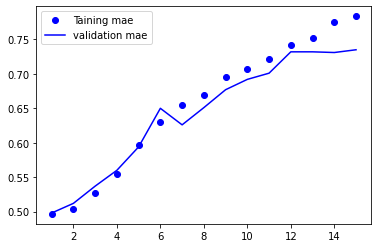

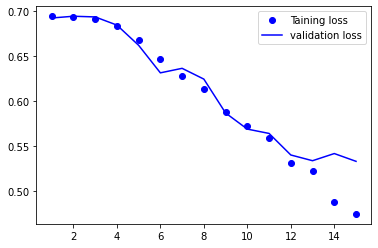

In [11]:
import matplotlib.pyplot as plt

acc=train_accuracy_history
val_acc=test_accuracy_history
loss=train_loss_history
val_loss=test_loss_history
epochs=range(1,epoch+1)

plt.figure()
plt.plot(epochs,acc,'bo',label='Taining mae')
plt.plot(epochs,val_acc,'b',label='validation mae')
plt.title=('Training and validation mae')
plt.legend()

plt.figure()
plt.plot(epochs,loss,'bo',label='Taining loss')
plt.plot(epochs,val_loss,'b',label='validation loss')
plt.title=('Training and validation loss')
plt.legend()


plt.show()

In [ ]:
torch.save(model,'siamise.path')